# ThaiME Codebook for All v2 Projects

Data for all ThaiME v2 projects are obtained on 2020-07-09.

In [1]:
#download and installs for colab
!npx degit pnphannisa/thaimaimee -f
!pip install fuzzywuzzy python-Levenshtein -q
!pip install pythainlp -q

npx: installed 1 in 2.431s
> destination directory is not empty. Using --force, continuing
> cloned pnphannisa/thaimaimee#master
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 13.1MB 70.1MB/s 
     |████████████████████████████████| 747kB 49.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import requests
import tqdm
import glob
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

def check_missing(df):
    per_missing = df.isnull().mean()
    missing_df = pd.DataFrame({'col': df.columns, 'per_missing': per_missing})
    missing_df = missing_df.sort_values('per_missing',ascending=False).reset_index(drop=True)
    missing_df['col'] = pd.Categorical(missing_df.col, categories=missing_df.col, ordered=True)
    return missing_df

In [3]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf.1') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

In [4]:
# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

## Clean Data

### Part 1

In [63]:
thaime = pd.read_excel('data/thaime_v2p1.xlsx')
thaime.columns = ['plan_nb','project_name','budget','unit','ministry','province','created_date','details_url']
thaime.shape

(9224, 8)

In [64]:
def str_to_float(x):
    try:
        return float(str(x).replace(',',''))
    except Exception as e:
        return None

#convert to numbers
thaime['budget'] = thaime.budget.map(str_to_float)
thaime.budget.describe()

count    9.224000e+03
mean     3.816149e+06
std      1.732435e+07
min      3.000000e+04
25%      4.870000e+05
50%      7.525000e+05
75%      3.136250e+06
max      9.800000e+08
Name: budget, dtype: float64

In [65]:
#remove text artifacts
for c in ['project_name','unit','ministry','province','created_date','details_url']:
    #remove \
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\\',''))
    #replace \n with /
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\n','/'))
    #replace nan with None
    thaime[c] = thaime[c].map(lambda x: None if str(x) in ['nan','-','None'] else x)

In [66]:
#created date
def split_date(x):
    try:
        splitted = str(x).replace('00:00:00','').split('-')
        return f'{int(splitted[0])-543}-{splitted[1].zfill(2)}-{splitted[2].zfill(2)}'
    except Exception as e:
        return e
thaime['created_date'] = thaime.created_date.map(split_date)

In [67]:
#oh, this time it's one project per province!
thaime.province.value_counts().reset_index().sort_values('province')

,index,province
20,ภูเก็ต,76
19,ระนอง,96
18,กระบี่,123
17,สตูล,124
16,ยะลา,138
15,นราธิวาส,231
14,พังงา,241
13,พิจิตร,270
12,ลำปาง,300
11,ปัตตานี,327


In [68]:
#handle ministries
ministries = pd.DataFrame(thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
                          .value_counts()).reset_index()
ministries.columns = ['ministry','cnt']
ministries

,ministry,cnt
0,มหาดไทย,9200
1,องค์กรปกครองส่วนท้องถิ่น,22
2,สำนักงานตำรวจแห่งชาติ,1
3,ศึกษาธิการ,1


In [70]:
thaime['ministry'] = thaime.ministry.map(lambda x: x.replace('กระทรวง',''))

In [71]:
#handle units
units = pd.DataFrame(thaime.unit.map(lambda x: x if x is not None else x)\
                          .value_counts()).reset_index()
units.columns = ['unit','cnt']
units

,unit,cnt
0,กรมส่งเสริมการปกครองท้องถิ่น,9028
1,องค์การบริหารส่วนจังหวัดแพร่,31
2,องค์การบริหารส่วนจังหวัดตรัง,21
3,องค์การบริหารส่วนจังหวัดอุทัยธานี,16
4,องค์การบริหารส่วนจังหวัดพัทลุง,15
5,องค์การบริหารส่วนจังหวัดกระบี่,13
6,องค์การบริหารส่วนจังหวัดนครสวรรค์,13
7,จังหวัดแพร่,13
8,องค์การบริหารส่วนจังหวัดสตูล,12
9,องค์การบริหารส่วนจังหวัดตาก,9


In [72]:
# thaime.to_csv('data/thaimaimee_v2p1.csv',index=False)

### Part 2

In [105]:
thaime = pd.read_excel('data/thaime_v2p2.xlsx')
thaime.columns = ['plan_nb','project_name','budget','unit','ministry','province','created_date','details_url','project_type']
thaime.shape

(31501, 9)

In [106]:
def str_to_float(x):
    try:
        return float(str(x).replace(',',''))
    except Exception as e:
        return None

#convert to numbers
thaime['budget'] = thaime.budget.map(str_to_float)
thaime.budget.describe()

count    3.148300e+04
mean     3.868567e+06
std      2.980863e+07
min      0.000000e+00
25%      4.810000e+05
50%      5.000000e+05
75%      2.690000e+06
max      3.200829e+09
Name: budget, dtype: float64

In [107]:
#remove text artifacts
for c in ['project_name','unit','ministry','province','created_date','details_url']:
    #remove \
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\\',''))
    #replace \n with /
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\n','/'))
    #replace nan with None
    thaime[c] = thaime[c].map(lambda x: None if str(x) in ['nan','-','None'] else x)

In [108]:
#not very consistent date format
thaime[thaime.created_date.map(lambda x: '-' not in x)].created_date.value_counts()

22 มิถุนายน 2563     1666
22 มิ.ย. 63          559 
22 มิ.ย.63           390 
19 มิถุนายน 2563     338 
22 มิย 63            56  
19  มิถุนายน 2563    2   
17 มิ.ย. 63          2   
Name: created_date, dtype: int64

In [109]:
#created date
def split_date(x):
    if '-' in x:
        try:
            splitted = str(x).replace('00:00:00','').split('-')
            return f'2020-{splitted[1].zfill(2)}-{splitted[2].zfill(2)}'
        except:
            return None
    else:
        try:
            return f'2020-06-{str(x).split()[0]}'
        except:
            return None

thaime['created_date'] = thaime.created_date.map(split_date)

In [110]:
thaime.created_date.value_counts()

2020-06-22     24891
2020-06-22     2671 
2020-06-19     1825 
2020-06-23     605  
2020-06-19     340  
              ...   
2020-06-12     2    
2020-06-14     2    
2020-06-11     2    
2020-06-20     2    
2020-06-10     2    
Name: created_date, Length: 369, dtype: int64

In [111]:
#oh, this time it's one project per province!
thaime.province.value_counts().reset_index().sort_values('province')

,index,province
46,พะเยา,1
45,สตูล,2
44,กระบี่,4
43,หนองบัวลำภู,6
42,อุบลราชธานี,13
41,ราชบุรี,38
40,สมุทรปราการ,56
39,สิงห์บุรี,77
38,นนทบุรี,98
37,พิษณุโลก,99


In [112]:
#handle ministries
ministries = pd.DataFrame(thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
                          .value_counts()).reset_index()
ministries.columns = ['ministry','cnt']
ministries

,ministry,cnt
0,มหาดไทย,31430
1,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,29
2,องค์กรปกครองส่วนท้องถิ่น,15
3,คมานคม,8
4,การท่องเที่ยวและกีฬา,3
5,คมนาคม,2
6,เกษตรและสหกรณ์,1
7,การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,1


In [113]:
thaime['ministry'] = thaime.ministry.map(lambda x: str(x).replace('กระทรวง',''))
thaime.loc[thaime['ministry'] == 'คมานคม', 'ministry'] = 'คมนาคม'
thaime.ministry.value_counts()

มหาดไทย                                      31430
ทรัพยากรธรรมชาติและสิ่งแวดล้อม               29   
องค์กรปกครองส่วนท้องถิ่น                     15   
None                                         12   
คมนาคม                                       10   
การท่องเที่ยวและกีฬา                         3    
เกษตรและสหกรณ์                               1    
การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม    1    
Name: ministry, dtype: int64

In [114]:
#handle units
units = pd.DataFrame(thaime.unit.map(lambda x: x if x is not None else x)\
                          .value_counts()).reset_index()
units.columns = ['unit','cnt']
units

,unit,cnt
0,กรมส่งเสริมการปกครองท้องถิ่น,28887
1,กรมส่งเสริมการปกครองส่วนท้องถิ่น,885
2,องค์การบริหารส่วนจังหวัดมหาสารคาม,315
3,องค์การบริหารส่วนจังหวัดยโสธร,284
4,องค์การบริหารส่วนจังหวัดบึงกาฬ,148
...,...,...
72,องค์การบริหารส่วนจังหวัดแม่ฮ่องสอน,1
73,องค์การบริการส่วนจังหวัดพระนครศรีอยุธยา,1
74,องค์การบริหารส่วนจังหวัดนนทบุรี,1
75,5004,1


In [115]:
#create dictionary of duplicate unit names
unit_dict = {}
for m in units.unit:
    i=0
    for k in unit_dict.keys():
        if fuzz.ratio(m,k)>95:
            i+=1
            unit_dict[k]+=f'|{m}'
    if i==0: unit_dict[m]=m

In [116]:
#replace with corrected name
correct_dict = {}
for k,v in unit_dict.items():
    vs = v.split('|')
    for v_ in vs:
        correct_dict[v_] = k

thaime['unit'] = thaime.unit.map(lambda x: correct_dict[x] if x is not None else x)
thaime.unit.value_counts()

กรมส่งเสริมการปกครองท้องถิ่น          28887
กรมส่งเสริมการปกครองส่วนท้องถิ่น      885  
องค์การบริหารส่วนจังหวัดมหาสารคาม     315  
องค์การบริหารส่วนจังหวัดยโสธร         284  
องค์การบริหารส่วนจังหวัดบึงกาฬ        148  
                                     ...   
15017                                 1    
องค์การบริหารส่วนจังหวัดแม่ฮ่องสอน    1    
องค์การบริหารส่วนจังหวัดนนทบุรี       1    
5004                                  1    
15015                                 1    
Name: unit, Length: 76, dtype: int64

In [117]:
unit_df = pd.DataFrame.from_dict(unit_dict,orient='index').reset_index()
unit_df.columns = ['key','val']
unit_df['nb_val'] = unit_df.val.map(lambda x: len(x.split('|')))
unit_df = unit_df.sort_values('nb_val',ascending=False).reset_index(drop=True)
for i,row in unit_df.head(5).iterrows():
    print(f"Unit name: {row['key']}")
    print(f"Variations: {row['val']}")
    print('-------------------------------------')

Unit name: องค์การบริหารส่วนจังหวัดพระนครศรีอยุธยา
Variations: องค์การบริหารส่วนจังหวัดพระนครศรีอยุธยา|องค์การบริการส่วนจังหวัดพระนครศรีอยุธยา
-------------------------------------
Unit name: กรมส่งเสริมการปกครองท้องถิ่น
Variations: กรมส่งเสริมการปกครองท้องถิ่น
-------------------------------------
Unit name: องค์การบริหารส่วนจังหวัดอ่างทอง
Variations: องค์การบริหารส่วนจังหวัดอ่างทอง
-------------------------------------
Unit name: 5460201
Variations: 5460201
-------------------------------------
Unit name: 15011
Variations: 15011
-------------------------------------


In [118]:
# thaime.to_csv('data/thaimaimee_v2p2.csv',index=False)

### Combine v2p1 and v2p2

In [119]:
p1 = pd.read_csv('data/thaimaimee_v2p1.csv')
p1['project_type'] = None
p2 = pd.read_csv('data/thaimaimee_v2p2.csv')
thaime = pd.concat([p1,p2]).reset_index(drop=True)
thaime

,plan_nb,project_name,budget,unit,ministry,province,created_date,details_url,project_type
0,3.2,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,866000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1310udhmdfXYpwox727N0FOQVC0NaQFTt/view?usp=drivesdk,None
1,3.2,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอย่างยั่งยืน,448500.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1qschiwWNOLsTIQ4I8zZKhdonEDIk80V5/view?usp=drivesdk,None
2,3.2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,200000000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1waJkTk6aEETHZrfJ6672-l6ULAxd2tPi/view?usp=drivesdk,None
3,3.2,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรองรับการท่องเที่ยวคุณภาพ,15000000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1bEsPvcIRY3ghL-gkCvshC3AJV1FgHBfL/view?usp=drivesdk,None
4,3.2,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทางดินซีเมนต์ ปรับปรุงคุณภาพด้วยยางธรรมชาติ สายพรุตีม๊ะ - ท่าเรือ หมู่ที่ 6 ตำบลอ่าวลึกน้อย อำเภออ่าวลึก จังหวัดกระบี่,9750000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1A1d5WBukfOFJ0p8h9weUEFW7sJpGyPLj/view?usp=drivesdk,None
...,...,...,...,...,...,...,...,...,...
40720,3.2,Gastronomy Tourism : Krabi Gastronomy “กระบี่-มรกตแห่งอันดามัน”,50000000.0,กระทรวงการอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,กระบี่,2020-06-22,https://drive.google.com/file/d/1S20bHRWC5qjfWvCMaRAy1fcPOlc2J3f-/view?usp=drivesdk,2
40721,3.2,จัดตั้งศูนย์ความปลอดภัยทางการท่องเที่ยวจังหวัดกระบี่,159800000.0,จังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1jHNSeB37c_A58cMF6ecQc134dhrQDopI/view?usp=drivesdk,3
40722,3.2,อัตลักษณ์สร้างมูลค่า และกระจายรายได้สู่ประชาชนคนกระบี่,30000000.0,จังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1RoOlHaSuLE_JN9ckHu6zrR1B_8olYMB2/view?usp=drivesdk,3
40723,3.2,โครงการพัฒนาส่งเสริมการท่องเที่ยวเชิงประวัติศาสตร์และวิถีชีวิตชุมชน ปรับปรุงศูนย์เรียนรู้อุทยานธรณีโลกสตูลที่สามารถพลิกฟื้นกิจกรรมการท่องเที่ยว การเรียนรู้ เพิ่มเศรษฐกิจ ยกระดับศักยภาพมาตรฐานการท่อเที่ยว,24997871.0,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,สตูล,2020-06-17,https://drive.google.com/file/d/1cmILOAn0Wzb7-JgMy546GXWveW5Hvn9O/view?usp=sharing,3


In [120]:
# thaime.to_csv('data/thaimaimee_v2.csv',index=False)

## Explore

In [135]:
thaime = pd.read_csv('data/thaimaimee_v2.csv')
thaime['budget_g'] = thaime.budget/1e9
thaime.head()

,plan_nb,project_name,budget,unit,ministry,province,created_date,details_url,project_type,budget_g
0,3.2,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,866000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1310udhmdfXYpwox727N0FOQVC0NaQFTt/view?usp=drivesdk,NaN,0.000866
1,3.2,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอย่างยั่งยืน,448500.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1qschiwWNOLsTIQ4I8zZKhdonEDIk80V5/view?usp=drivesdk,NaN,0.000449
2,3.2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,200000000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1waJkTk6aEETHZrfJ6672-l6ULAxd2tPi/view?usp=drivesdk,NaN,0.200000
3,3.2,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรองรับการท่องเที่ยวคุณภาพ,15000000.0,องค์การบริหารส่วนจังหวัดกระบี่,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1bEsPvcIRY3ghL-gkCvshC3AJV1FgHBfL/view?usp=drivesdk,NaN,0.015000
4,3.2,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทางดินซีเมนต์ ปรับปรุงคุณภาพด้วยยางธรรมชาติ สายพรุตีม๊ะ - ท่าเรือ หมู่ที่ 6 ตำบลอ่าวลึกน้อย อำเภออ่าวลึก จังหวัดกระบี่,9750000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,2020-06-22,https://drive.google.com/file/d/1A1d5WBukfOFJ0p8h9weUEFW7sJpGyPLj/view?usp=drivesdk,NaN,0.009750


### Missing Data

In [136]:
#some missing data but not too many
check_missing(thaime)

,col,per_missing
0,project_type,0.226495
1,details_url,0.168079
2,plan_nb,0.028189
3,unit,0.000688
4,budget,0.000442
5,budget_g,0.000442
6,project_name,0.000000
7,ministry,0.000000
8,province,0.000000
9,created_date,0.000000


### Budget Breakdown by Ministry

In [140]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,มหาดไทย,154.128756
1,อื่นๆ,2.865511


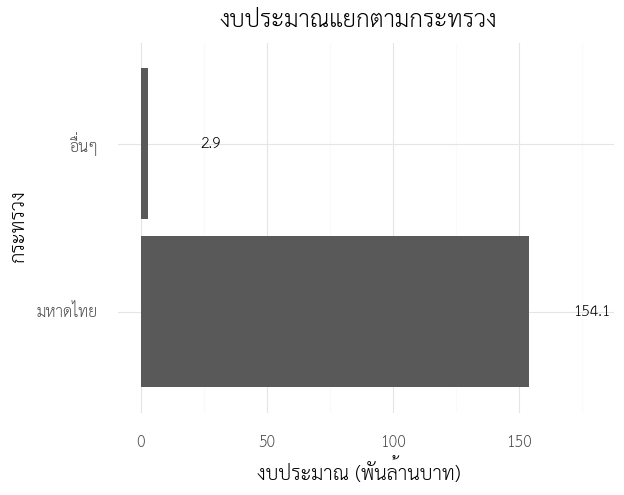

<ggplot: (8779978264440)>

In [141]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='ministry_',y='budget_g+25',label='round(budget_g,1)')) +
     coord_flip() + ggtitle('งบประมาณแยกตามกระทรวง'))
g

In [ ]:
# bbm['thailand'] = 'thailand'
# fig = px.treemap(bbm, path=['thailand','ministry'], 
#                  values='budget_g',
#                   color='budget_g',
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=bbm.budget_g.quantile(0.95))
# fig.update_layout(uniformtext=dict(minsize=20, mode=False))
# fig.show()

## Number of Projects by Ministry

In [142]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.count()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<10000 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,มหาดไทย,40612
1,อื่นๆ,95


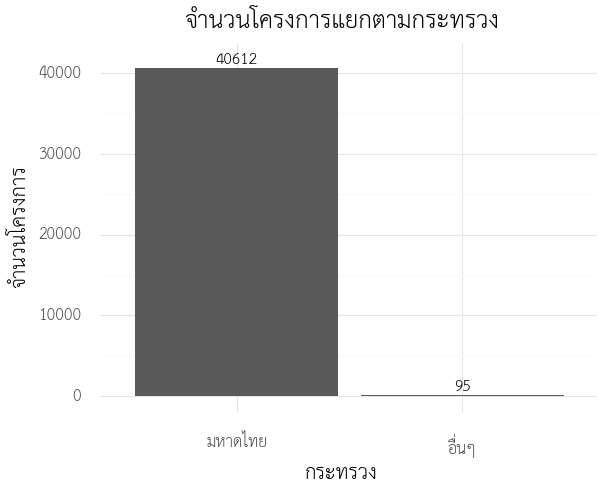

<ggplot: (8779978290317)>

In [143]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='ministry_',y='budget_g+1000',label='round(budget_g,1)')) +
     ggtitle('จำนวนโครงการแยกตามกระทรวง'))
g

### Top Projects

In [144]:
bbm = pd.DataFrame(thaime.groupby(['project_name','ministry']).budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True).head(10)
bbm

,project_name,ministry,budget_g
0,โครงการด้านโครงสร้างพื้นฐาน,มหาดไทย,3.200829
1,การพัฒนาโครงสร้างพื้นฐานในชุมชน,มหาดไทย,1.881054
2,โครงการพัฒนาและปรับปรุงเส้นทางคมนาคมชุมชนและไฟฟ้าส่องสว่าง,มหาดไทย,1.443733
3,โครงการด้านอื่นๆ,มหาดไทย,1.395026
4,ปรับปรุงและพัฒนาแหล่งน้ำชุมชนเพื่ออุปโภค บริโภคและการเกษตร,มหาดไทย,1.383778
5,โครงการพัฒนาเครือข่ายโลจิสติกส์ด้านการขนส่งสินค้าทางถนน,มหาดไทย,1.017690
6,"โครงการพัฒนาแหล่งน้ำเพื่อแก้ไขน้ำท่วมและภัยแล้ง (ขุดลอก)ขุดลอกแหล่งน้ำในเขตพื้นที่ตำบลนาหนองไผ่ อำเภอชุมพลบุรี จังหวัดสุรินทร์ขนาดกว้าง 8.00 เมตร ยาว 100,000 เมตร พื้นที่ขุดลอก 800,000 ตารางเมตร ลึกเฉลี่ย 3.00 เมตร ลาดเอียง 1 : 1 ปริมาตรดินขุด 2,400,000 ลูกบาศก์เมตร",มหาดไทย,1.009930
7,โครงการก่อสร้างระบบจ่ายน้ำดิบสำหรับระบบการผลิตน้ำประปาเพื่อพัฒนาคุณภาพชีวิตและเศรษฐกิจของท้องถิ่นและชุมชน,มหาดไทย,0.980000
8,โครงการส่งเสริมและพัฒนาโครงสร้างพื้นฐานขององค์กรปกครองส่วนท้องถิ่น,มหาดไทย,0.848791
9,โครงการหนองคายเมืองแห่งการท่องเที่ยว/(The city of Tourism),มหาดไทย,0.773886


### Project Size Distribution

In [145]:
thaime['digits'] = thaime.budget.map(lambda x: len(str(round(x))) if x==x else x)
dg = thaime.groupby('digits').project_name.count().reset_index()
dg

,digits,project_name
0,1.0,2
1,4.0,1
2,5.0,354
3,6.0,23933
4,7.0,14057
5,8.0,2228
6,9.0,126
7,10.0,6


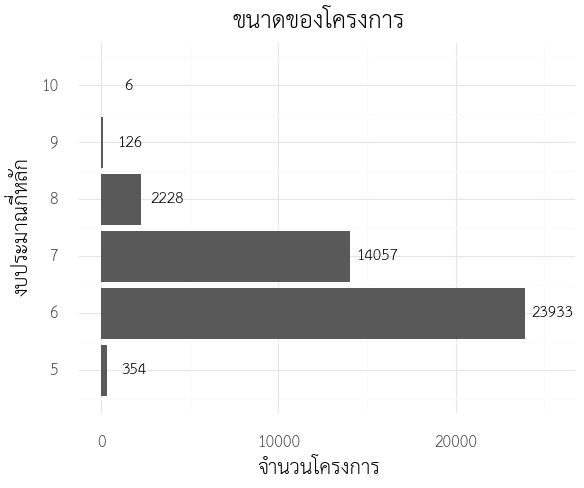

<ggplot: (8779987479777)>

In [146]:
g = (ggplot(dg[dg.digits>4], aes(x='digits',y='project_name')) + geom_col() +
     xlab('งบประมาณกี่หลัก') + ylab('จำนวนโครงการ') +
     scale_x_continuous(breaks=[i for i in range(13)])+
     geom_text(aes(x='digits',y='project_name+1500',label='round(project_name,1)')) +
     coord_flip() + ggtitle('ขนาดของโครงการ'))
g

### Project Size by Ministry

In [147]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
# bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
bbm['ministry_'] = bbm.ministry
top_ministries = list(bbm.ministry_)
top_ministries

['มหาดไทย',
 'องค์กรปกครองส่วนท้องถิ่น',
 'ทรัพยากรธรรมชาติและสิ่งแวดล้อม',
 'คมนาคม',
 'การท่องเที่ยวและกีฬา',
 'การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม',
 'None',
 'สำนักงานตำรวจแห่งชาติ',
 'เกษตรและสหกรณ์',
 'ศึกษาธิการ']

In [148]:
thaime2 = thaime.copy()
thaime2['ministry'] = thaime2.ministry.map(lambda x: 'อื่นๆ' if x not in top_ministries else x)

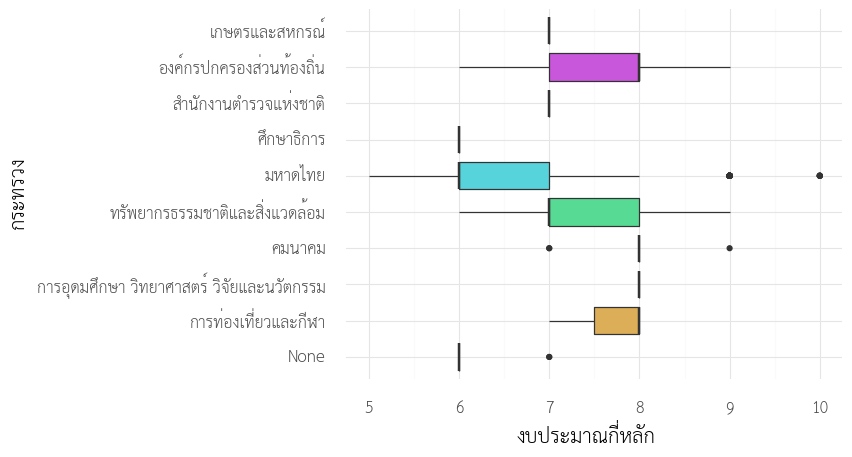

<ggplot: (8779988177928)>

In [150]:
g = (ggplot(thaime2[thaime2.digits>4], aes(x='ministry',y='digits',fill='ministry')) + geom_boxplot() +
    theme(legend_position='none') + xlab('กระทรวง') + ylab('งบประมาณกี่หลัก') +
    scale_y_continuous(breaks=[i for i in range(13)])+
    coord_flip())
g

### Project Name Word Cloud

In [151]:
import pythainlp
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [152]:
texts = []
for i in range(thaime.shape[0]):
    texts+=[i for i in word_tokenize(thaime.project_name[i], keep_whitespace=False) if len(i)>2]
text = ' '.join(texts)
text[:100]

'ส่งเสริม การ สร้าง รายได้ ด้วย การจ้างแรงงาน ตัด หญ้า พัฒนา ศักยภาพ และ เสริมสร้าง ความเข้มแข็ง ของ '

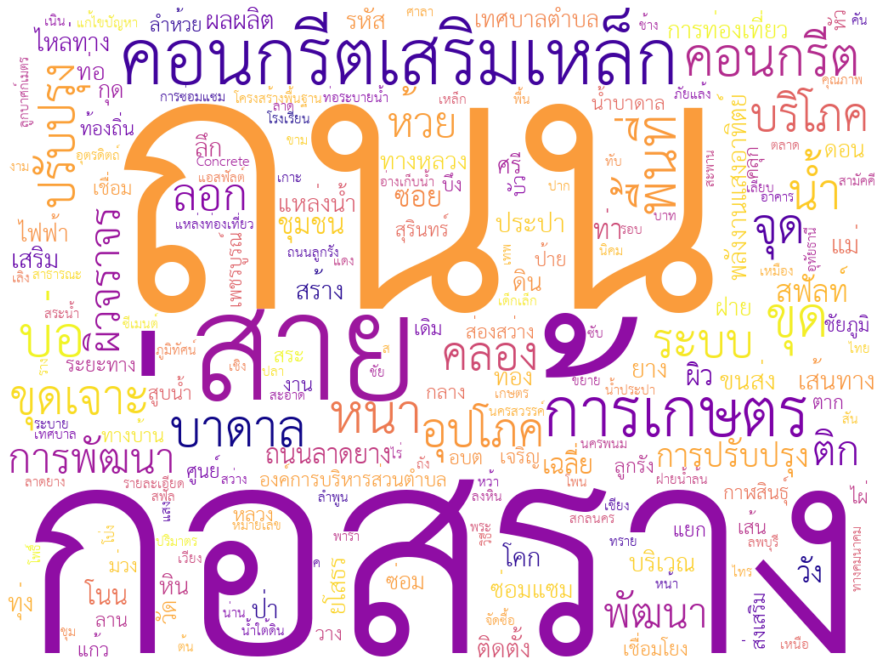

In [153]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf.1',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['โครงการ','โครง',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### Projects with Specific Keywords: Constructions, Roads and Canels

In [154]:
constructions = ['ก่อสร้าง','คอนกรีต']
roads = ['ถนน','ทางหลวง','อัสฟัล','ผิวจราจร']
canels = ['คลอง','ขุดลอก']

thaime['constructions'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in constructions]) else 'ไม่ใช่')
thaime['roads'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in roads]) else 'ไม่ใช่')
thaime['canels'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in canels]) else 'ไม่ใช่')

In [155]:
bbm = pd.DataFrame(thaime.groupby('constructions').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,constructions,sum,len
0,ไม่ใช่,81.058580,19372.0
1,ใช่,75.935687,21353.0


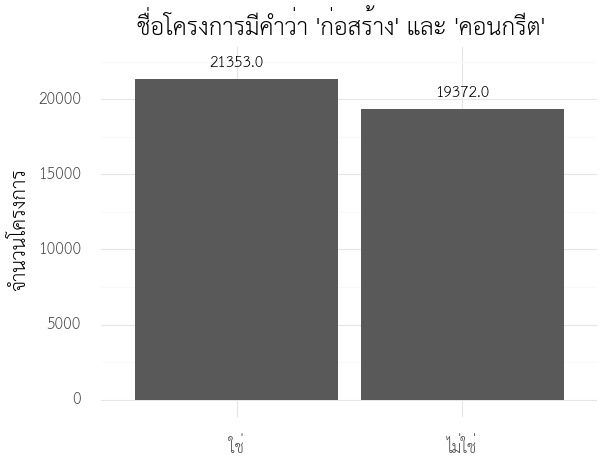

<ggplot: (8779962102827)>

In [156]:
g = (ggplot(bbm, aes(x='constructions',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='constructions',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

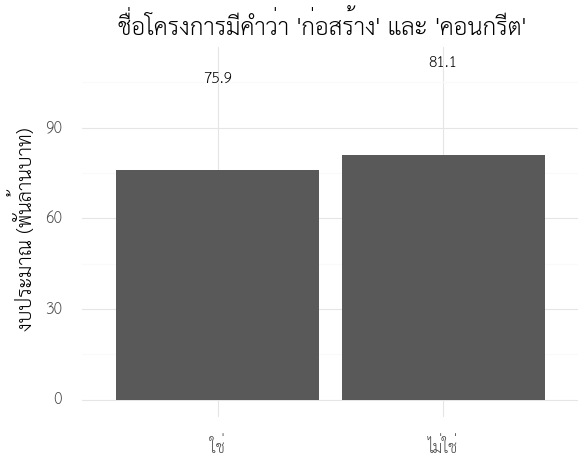

<ggplot: (-9223363256892677944)>

In [157]:
g = (ggplot(bbm, aes(x='constructions',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='constructions',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

In [158]:
bbm = pd.DataFrame(thaime.groupby('roads').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,roads,sum,len
0,ไม่ใช่,88.957687,21316.0
1,ใช่,68.036580,19409.0


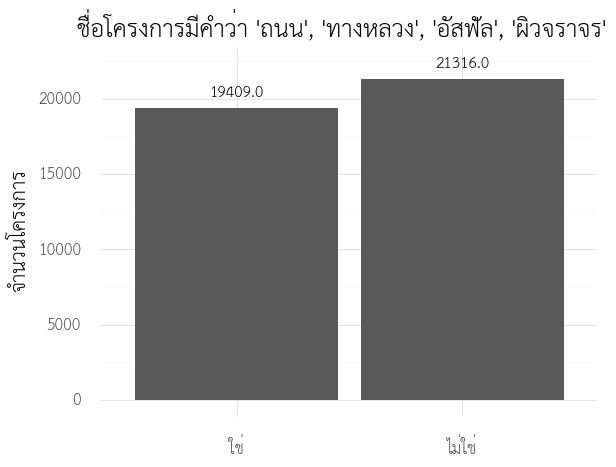

<ggplot: (-9223363256876485923)>

In [159]:
g = (ggplot(bbm, aes(x='roads',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='roads',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

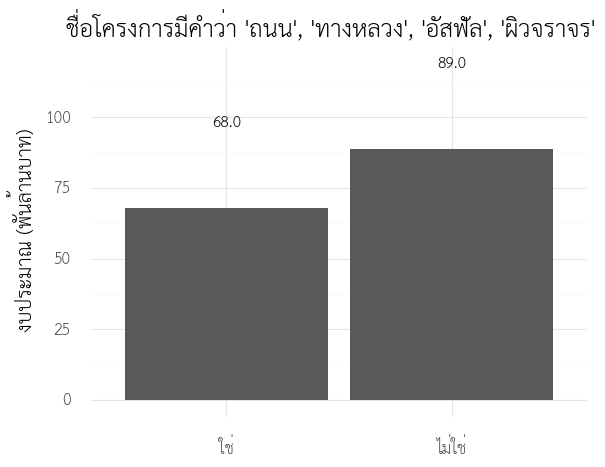

<ggplot: (-9223363256892696674)>

In [160]:
g = (ggplot(bbm, aes(x='roads',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='roads',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

In [161]:
bbm = pd.DataFrame(thaime.groupby('canels').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,canels,sum,len
0,ไม่ใช่,139.192135,35556.0
1,ใช่,17.802133,5169.0


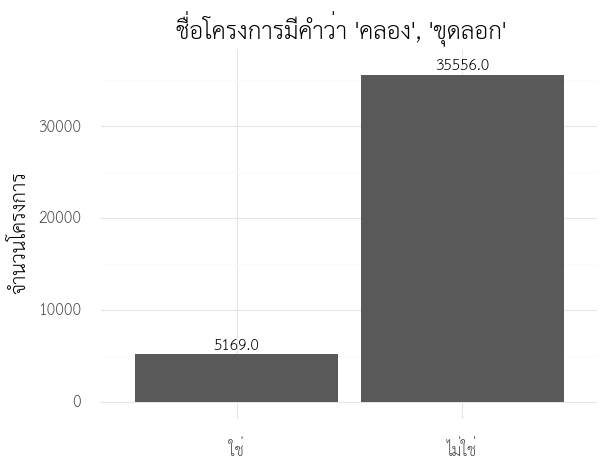

<ggplot: (8779962079012)>

In [162]:
g = (ggplot(bbm, aes(x='canels',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g

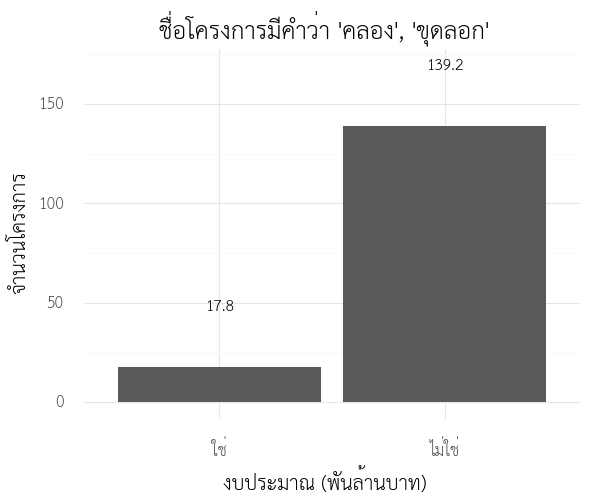

<ggplot: (-9223363256896701089)>

In [163]:
g = (ggplot(bbm, aes(x='canels',y='sum')) + geom_col() +
     xlab('งบประมาณ (พันล้านบาท)') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g